## Joscha Model (VIT Large Dinov2)

1. Easy debug: pass in a few images adn check the output (embeddings + classification)

2. Check which layers are added to the normal vit model (instead of removing weight params)

3. There's obvious bugs in the code: check the outputs and observe why 

4. datasets

In [20]:
import os
import numpy as np
import torch
import cv2
from timm import create_model
from torchvision import transforms
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # For progress bars
import torch
from timm import create_model
import timm
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Paths to model and data

joscha_checkpoint_path = "/workspaces/gorilla_watch/video_data/gorillawatch/gorillatracker/models/vit_large_dinov2_ssl_joscha.ckpt"
robert_checkpoint_path = "/workspaces/gorilla_watch/video_data/gorillawatch/gorillatracker/models/supervised_dinov2_large.ckpt"
vincent_checkpoint_path = "/workspaces/gorilla_watch/video_data/gorillawatch/gorillatracker/models/ssl_vincent_vit_large.ckpt"

#checkpoint_path = robert_checkpoint_path
test_folder = "/workspaces/gorilla_watch/video_data/gorillawatch/gorillatracker/datasets/cxl_all_split_60-25-15/test"
train_folder = "/workspaces/gorilla_watch/video_data/gorillawatch/gorillatracker/datasets/cxl_all_split_60-25-15/train"
val_folder = "/workspaces/gorilla_watch/video_data/gorillawatch/gorillatracker/datasets/cxl_all_split_60-25-15/val"

all_folder = "/workspaces/gorilla_watch/video_data/gorillawatch/gorillatracker/datasets/cxl_all_face"


## Joscha Laden

In [22]:
checkpoint_path = joscha_checkpoint_path

# Initialize the ViT model
vit_model = create_model('vit_large_patch14_dinov2.lvd142m', pretrained=False, img_size=192)

# Load checkpoint and extract state_dict
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))
print(checkpoint["hyper_parameters"])
# print(checkpoint["hparams_name"])
# print(checkpoint["state_dict"].keys())

state_dict = checkpoint.get('state_dict', checkpoint)  # Get 'state_dict' or use checkpoint directly if no wrapper exists


/tmp/ipykernel_126331/1591828169.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))


{'wandb_run': <wandb.sdk.wandb_run.Run object at 0x7efdbc18bfd0>, 'loss_mode': 'offline/native', 'from_scratch': False, 'weight_decay': 0.05965933391940936, 'lr_schedule': 'exponential', 'warmup_mode': 'constant', 'warmup_epochs': 0, 'max_epochs': 50, 'initial_lr': 1e-05, 'start_lr': 7.80348169667904e-06, 'end_lr': 1e-07, 'stepwise_schedule': True, 'lr_interval': 1, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-07, 'embedding_size': 256, 'batch_size': 64, 'dataset_names': ['cxlkfold', 'bristol', 'cxl_test'], 'accelerator': 'cuda', 'dropout_p': 0.0037839155823639614, 'use_dist_term': False, 'use_inbatch_mixup': False, 'kfold_k': None, 'knn_with_train': False, 'use_quantization_aware_training': False, 'every_n_val_epochs': 100, 'fast_dev_run': False, 'margin': 1.0980768203313964, 's': 64.0, 'temperature': 0.5, 'memory_bank_size': 0, 'num_classes': None, 'class_distribution': None, 'l2_alpha': 0.095, 'l2_beta': 0.022, 'path_to_pretrained_weights': 'pretrained_weights/ViT_Large_DinoV2.pth', 

In [23]:
### compare checkpoints' state_dict with a standard model's state_dict

new_state_dict = {k.replace('model_wrapper.', ''): v for k, v in state_dict.items()}
new_state_dict2 = {k.replace('model.', ''): v for k, v in new_state_dict.items()}


# Standard ViT model keys
standard_vit_keys = vit_model.state_dict().keys()

# Compare keys
custom_keys = new_state_dict2.keys()
missing_in_standard = [k for k in custom_keys if k not in standard_vit_keys]
extra_in_standard = [k for k in standard_vit_keys if k not in custom_keys]

print("Missing keys in standard ViT:", missing_in_standard)
print("Extra keys in standard ViT:", extra_in_standard)

# print(new_state_dict2)

for key in missing_in_standard:
    print(f"{key}: {new_state_dict2[key].shape}")
    
embedding_keys = [key for key in new_state_dict2.keys() if "embedding_layer" in key]
print(embedding_keys)
    


Missing keys in standard ViT: ['embedding_layer.0.weight', 'embedding_layer.0.bias', 'embedding_layer.0.running_mean', 'embedding_layer.0.running_var', 'embedding_layer.0.num_batches_tracked', 'embedding_layer.2.weight', 'embedding_layer.2.bias', 'embedding_layer.3.weight', 'embedding_layer.3.bias', 'embedding_layer.3.running_mean', 'embedding_layer.3.running_var', 'embedding_layer.3.num_batches_tracked']
Extra keys in standard ViT: []
embedding_layer.0.weight: torch.Size([1024])
embedding_layer.0.bias: torch.Size([1024])
embedding_layer.0.running_mean: torch.Size([1024])
embedding_layer.0.running_var: torch.Size([1024])
embedding_layer.0.num_batches_tracked: torch.Size([])
embedding_layer.2.weight: torch.Size([256, 1024])
embedding_layer.2.bias: torch.Size([256])
embedding_layer.3.weight: torch.Size([256])
embedding_layer.3.bias: torch.Size([256])
embedding_layer.3.running_mean: torch.Size([256])
embedding_layer.3.running_var: torch.Size([256])
embedding_layer.3.num_batches_tracked: t

In [24]:
# wrap the VIT model with custom layers

class CustomVisionTransformer(nn.Module):
    def __init__(self, base_vit):
        super(CustomVisionTransformer, self).__init__()
        self.base_vit = base_vit
        
        # Define embedding layers based on checkpoint dimensions
        self.embedding_layer_0 = nn.BatchNorm1d(1024)  # Normalize input size 1024
        self.embedding_layer_2 = nn.Linear(1024, 256)  # Linear layer: 1024 -> 256
        self.embedding_layer_3 = nn.BatchNorm1d(256)  # Normalize input size 256

    def forward(self, x):
        # Pass input through the Vision Transformer backbone
        x = self.base_vit.forward_features(x)  # Output size is [batch_size, 1024]
        print(f"output shape of base_vit: {x.shape}")
        
        # Flatten the patch and token dimensions into batch
        # x = x.view(-1, x.size(-1))  # Shape: [batch_size * 257, 1024]
        x = x[:, 0, :]  # Shape: [batch_size, 1024]

        
        # Pass through the additional embedding layers
        x = self.embedding_layer_0(x)  # BatchNorm1d for 1024
        print(f"output shape of embedding_layer_0: {x.shape}")
        x = self.embedding_layer_2(x)  # Linear transformation to 256
        print(f"output shape of embedding_layer_2: {x.shape}")
        x = self.embedding_layer_3(x)  # BatchNorm1d for 256
        print(f"output shape of embedding_layer_3: {x.shape}")
        
        return x

# Initialize the base ViT model
base_vit = create_model('vit_large_patch14_224', pretrained=False)

# Wrap the base ViT model with the custom embedding layers
custom_vit = CustomVisionTransformer(base_vit)


In [25]:
# load the checkpoints' state_dict into the custom model
 
# print(state_dict.keys()) # observe the keys in the state_dict

# Adjust the keys
adjusted_state_dict = {k.replace("model_wrapper.", ""): v for k, v in state_dict.items()}
backbone_keys_adjusted = {k.replace("model.", ""): v for k, v in adjusted_state_dict.items()}

# Separate backbone and embedding layers
backbone_state_dict = {k: v for k, v in backbone_keys_adjusted.items() if "embedding_layer" not in k}
filtered_backbone_state_dict = {k: v for k, v in backbone_state_dict.items() if "ls1.gamma" not in k and "ls2.gamma" not in k}

import torch.nn.functional as F

# Resize the positional embeddings
checkpoint_pos_embed = backbone_state_dict["pos_embed"]
checkpoint_pos_embed = checkpoint_pos_embed.view(1, 170, -1)  # Flatten
new_pos_embed = F.interpolate(checkpoint_pos_embed.permute(0, 2, 1), size=257, mode='linear')  # Interpolate
new_pos_embed = new_pos_embed.permute(0, 2, 1).view(1, 257, -1)

# Replace the key in the state_dict
filtered_backbone_state_dict["pos_embed"] = new_pos_embed

embedding_layer_state_dict = {k: v for k, v in backbone_keys_adjusted.items() if "embedding_layer" in k}


# Load weights into the backbone (base_vit)
custom_vit.base_vit.load_state_dict(filtered_backbone_state_dict, strict=False)

# Load weights into the embedding layers
custom_vit.embedding_layer_0.load_state_dict({
    "weight": embedding_layer_state_dict["embedding_layer.0.weight"],
    "bias": embedding_layer_state_dict["embedding_layer.0.bias"],
    "running_mean": embedding_layer_state_dict["embedding_layer.0.running_mean"],
    "running_var": embedding_layer_state_dict["embedding_layer.0.running_var"],
    "num_batches_tracked": embedding_layer_state_dict["embedding_layer.0.num_batches_tracked"],
})
custom_vit.embedding_layer_2.load_state_dict({
    "weight": embedding_layer_state_dict["embedding_layer.2.weight"],
    "bias": embedding_layer_state_dict["embedding_layer.2.bias"],
})
custom_vit.embedding_layer_3.load_state_dict({
    "weight": embedding_layer_state_dict["embedding_layer.3.weight"],
    "bias": embedding_layer_state_dict["embedding_layer.3.bias"],
    "running_mean": embedding_layer_state_dict["embedding_layer.3.running_mean"],
    "running_var": embedding_layer_state_dict["embedding_layer.3.running_var"],
    "num_batches_tracked": embedding_layer_state_dict["embedding_layer.3.num_batches_tracked"],
})

# custom_vit.to(device)
custom_vit.eval()


CustomVisionTransformer(
  (base_vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GEL

In [26]:
# ### Max' approach to loading the state_dict

# # Adjust the keys if necessary (remove any prefix like 'model.')
# new_state_dict = {k.replace('model_wrapper.', ''): v for k, v in state_dict.items()}
# new_state_dict2 = {k.replace('model.', ''): v for k, v in new_state_dict.items()}

# # Filter out unexpected keys from the state_dict
# model_keys = set(vit_model.state_dict().keys())
# filtered_state_dict = {k: v for k, v in new_state_dict2.items() if k in model_keys}

# # Load the filtered state_dict into the model
# vit_model.load_state_dict(filtered_state_dict, strict=True)
# vit_model.eval()  # Set to evaluation mode

# ### MAx' approach

In [27]:
# load the data
# Preprocessing function to resize and normalize images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust based on model pretraining
])

# Load images and extract class codes from file names
def load_images_and_labels(folder):
    images = []
    labels = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image = cv2.imread(os.path.join(folder, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = transform(image)
            images.append(image)
            labels.append(filename[:4])  # Assuming first 4 chars are label
            
            filenames.append(filename)
    
    return images, labels

# Load data
test_images, test_labels = load_images_and_labels(test_folder)
# train_images, train_labels = load_images_and_labels(train_folder)
# val_images, val_labels = load_images_and_labels(val_folder)
# all_images, all_labels = load_images_and_labels(all_folder)

test_images_tensor = torch.stack(test_images)
# train_images_tensor = torch.stack(train_images)
# val_images_tensor = torch.stack(val_images)
# all_images_tensor = torch.stack(all_images)

# train_val_images_tensor = torch.cat((train_images_tensor, val_images_tensor), 0)
# train_val_labels = train_labels + val_labels


## Robert Loading

In [28]:
# checkpoint_path = robert_checkpoint_path
# # Initialize the ViT model
# vit_model = create_model('vit_large_patch14_dinov2.lvd142m', pretrained=False, img_size=192)

# # Load checkpoint and extract state_dict
# checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))
# state_dict = checkpoint.get('state_dict', checkpoint)  # Get 'state_dict' or use checkpoint directly if no wrapper exists

# # Adjust the keys if necessary (remove any prefix like 'model.')
# new_state_dict = {k.replace('model_wrapper.', ''): v for k, v in state_dict.items()}
# new_state_dict2 = {k.replace('model.', ''): v for k, v in new_state_dict.items()}

# # Interpolate positional embeddings if size mismatch
# if 'pos_embed' in new_state_dict2:
#     pos_embed_checkpoint = new_state_dict2['pos_embed']
#     pos_embed_model = vit_model.state_dict()['pos_embed']
#     if pos_embed_checkpoint.shape != pos_embed_model.shape:
#         print(f"Interpolating pos_embed from {pos_embed_checkpoint.shape} to {pos_embed_model.shape}")
#         num_patches = pos_embed_model.shape[1] - 1  # Exclude class token
#         class_pos_embed = pos_embed_checkpoint[:, :1, :]  # Class token
#         patch_pos_embed = pos_embed_checkpoint[:, 1:, :]  # Patch tokens

#         # Reshape and interpolate patch embeddings
#         patch_pos_embed = patch_pos_embed.reshape(1, int(patch_pos_embed.size(1)**0.5), -1, patch_pos_embed.size(-1))
#         patch_pos_embed = torch.nn.functional.interpolate(
#             patch_pos_embed.permute(0, 3, 1, 2),  # Convert to NCHW for interpolation
#             size=(int(num_patches**0.5), int(num_patches**0.5)),  # Target size
#             mode='bilinear',
#             align_corners=False
#         ).permute(0, 2, 3, 1).reshape(1, num_patches, -1)  # Back to NHWC

#         # Concatenate class token and interpolated patch embeddings
#         new_pos_embed = torch.cat((class_pos_embed, patch_pos_embed), dim=1)
#         new_state_dict2['pos_embed'] = new_pos_embed


# # # Filter out unexpected keys from the state_dict
# # model_keys = set(vit_model.state_dict().keys())
# # filtered_state_dict = {k: v for k, v in new_state_dict2.items() if k in model_keys}

# # Load the filtered state_dict into the model
# vit_model.load_state_dict(filtered_state_dict, strict=True)
# vit_model.eval()  # Set to evaluation mode

# # Preprocessing function to resize and normalize images
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((192, 192)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust based on model pretraining
# ])

# # Load images and extract class codes from file names
# def load_images_and_labels(folder):
#     images = []
#     labels = []
#     for filename in os.listdir(folder):
#         if filename.endswith('.jpg') or filename.endswith('.png'):
#             image = cv2.imread(os.path.join(folder, filename))
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             image = transform(image)
#             images.append(image)
#             labels.append(filename[:4])  # Assuming first 4 chars are label
#     return images, labels

# # Load data
# images, labels = load_images_and_labels(data_folder)
# images_tensor = torch.stack(images)


## Using the custom model

In [29]:
# Function to generate embeddings from a model
def generate_embeddings(model, images_tensor):
    with torch.no_grad():
        # Call the forward method to extract embeddings
        embeddings = model(images_tensor)
    return embeddings

# test_images_tensor = test_images_tensor.to(device)
# all_images_tensor = all_images_tensor.to(device)
# Generate and flatten embeddings for ViT
test_vit_embeddings = generate_embeddings(custom_vit, test_images_tensor)
# train_val_vit_embeddings = generate_embeddings(custom_vit, train_val_images_tensor)
# all_vit_embeddings = generate_embeddings(custom_vit, all_images_tensor)

# Flatten the embeddings
test_vit_embeddings_flat = test_vit_embeddings.view(test_vit_embeddings.size(0), -1).numpy()
# train_val_vit_embeddings_flat = train_val_vit_embeddings.view(train_val_vit_embeddings.size(0), -1).numpy()
# all_vit_embeddings_flat = all_vit_embeddings.view(all_vit_embeddings.size(0), -1).numpy()




output shape of base_vit: torch.Size([54, 257, 1024])
output shape of embedding_layer_0: torch.Size([54, 1024])
output shape of embedding_layer_2: torch.Size([54, 256])
output shape of embedding_layer_3: torch.Size([54, 256])


In [30]:
# # try normalize or reduce embeddings

# from sklearn.preprocessing import normalize

# # Normalize embeddings
# all_vit_embeddings_normalized = normalize(all_vit_embeddings_flat, axis=1)
# test_vit_embeddings_normalized = normalize(test_vit_embeddings_flat, axis=1)

# from sklearn.decomposition import PCA

# # Apply PCA to reduce dimensionality
# pca = PCA(n_components=50)  # Experiment with n_components (e.g., 50 or 100)
# all_vit_embeddings_reduced = pca.fit_transform(all_vit_embeddings_normalized)
# test_vit_embeddings_reduced = pca.transform(test_vit_embeddings_normalized)

# print(f"PCA explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")


So far we have generate the embeddings for the test and all images. Now we can use the embeddings to train a KNN classifier.

Update: use only test embeddings: pass all of them into KNN, iterate through the test element and classify it by removing its nearest neighbor

In [34]:
# try reducing smaples with insufficient data

from collections import Counter
threshold = 3

# Count occurrences of each label
label_counts = Counter(test_labels)
print(f"Number of images before filtering: {len(test_labels)}")

# 
# Filter embeddings and labels for individuals with >= 3 samples
filtered_indices = [i for i, label in enumerate(test_labels) if label_counts[label] >= threshold]
test_vit_embeddings_filtered = test_vit_embeddings_flat[filtered_indices]
test_labels_filtered = [test_labels[i] for i in filtered_indices]

# check the number of images after filtering
print(f"Number of images after filtering: {len(test_labels_filtered)}")
print(f"Number of images after filtering: {len(test_vit_embeddings_filtered)}")


Number of images before filtering: 54
Number of images after filtering: 40
Number of images after filtering: 40


In [36]:
# KNN classifier and excluding the closest neighbor (self-matching)
def knn_classifier(embeddings, labels):
    for k in range(1, 10):
        # Use k+1 neighbors to account for excluding self
        vit_knn = KNeighborsClassifier(n_neighbors=k + 1)
        vit_knn.fit(embeddings, labels)  # Fit KNN on all data

        vit_y_pred = []
        for idx, test_embedding in enumerate(embeddings):
            # Find k+1 neighbors (including the test sample itself)
            neighbors = vit_knn.kneighbors(test_embedding.reshape(1, -1), return_distance=False)[0]

            # Exclude the test sample itself (assumed to be the closest neighbor)
            filtered_neighbors = neighbors[1:]  # Exclude the first neighbor
        
            # Predict based on the remaining neighbors (majority vote)
            filtered_neighbor_labels = [labels[n] for n in filtered_neighbors]
            predicted_label = max(set(filtered_neighbor_labels), key=filtered_neighbor_labels.count)
            vit_y_pred.append(predicted_label)

        # Calculate accuracy for the current k
        vit_accuracy = accuracy_score(labels, vit_y_pred)
        print(f"ViT Accuracy with {k}-nearest neighbors (excluding self): {vit_accuracy:.4f}")
        

# knn_classifier(all_vit_embeddings_reduced, all_labels, test_vit_embeddings_reduced, test_labels)
# knn_classifier(all_vit_embeddings_filtered, all_labels_filtered, test_vit_embeddings_flat, test_labels)
print("all test samples")
knn_classifier(test_vit_embeddings_flat, test_labels)
print(f"filtered test samples (threshold = {threshold})")
knn_classifier(test_vit_embeddings_filtered, test_labels_filtered)


all test samples
ViT Accuracy with 1-nearest neighbors (excluding self): 0.2778
ViT Accuracy with 2-nearest neighbors (excluding self): 0.2593
ViT Accuracy with 3-nearest neighbors (excluding self): 0.2593
ViT Accuracy with 4-nearest neighbors (excluding self): 0.2037
ViT Accuracy with 5-nearest neighbors (excluding self): 0.2037
ViT Accuracy with 6-nearest neighbors (excluding self): 0.2222
ViT Accuracy with 7-nearest neighbors (excluding self): 0.1667
ViT Accuracy with 8-nearest neighbors (excluding self): 0.1296
ViT Accuracy with 9-nearest neighbors (excluding self): 0.1111
filtered test samples (threshold = 3)
ViT Accuracy with 1-nearest neighbors (excluding self): 0.4000
ViT Accuracy with 2-nearest neighbors (excluding self): 0.3500
ViT Accuracy with 3-nearest neighbors (excluding self): 0.2750
ViT Accuracy with 4-nearest neighbors (excluding self): 0.3000
ViT Accuracy with 5-nearest neighbors (excluding self): 0.3250
ViT Accuracy with 6-nearest neighbors (excluding self): 0.2250


Letztes mal:

ViT Accuracy: 0.6667 (Mit test_size 0.05)

/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


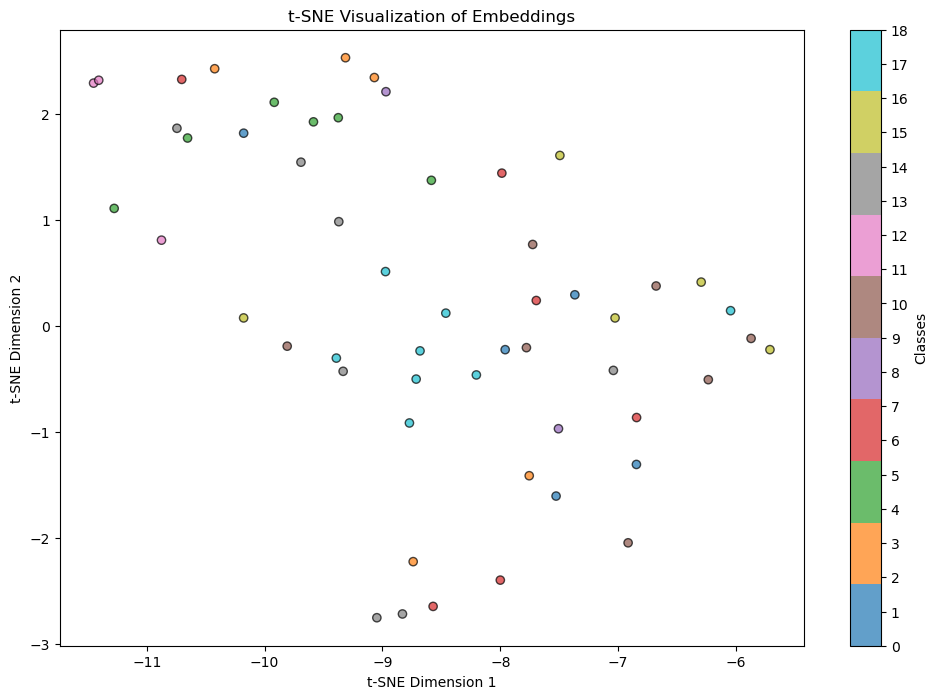

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming `all_vit_embeddings_flat` contains all embeddings
# and `all_labels` contains corresponding labels

# Using t-SNE to reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
# reduced_embeddings_tsne = tsne.fit_transform(all_vit_embeddings_flat)
reduced_embeddings_tsne = tsne.fit_transform(test_vit_embeddings_flat)

# Convert labels to numeric values for coloring
unique_labels = list(set(test_labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels = [label_to_index[label] for label in test_labels]

# Visualizing the reduced embeddings with a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_embeddings_tsne[:, 0],
    reduced_embeddings_tsne[:, 1],
    c=numeric_labels,
    cmap="tab10",
    alpha=0.7,
    edgecolor="k"
)
plt.colorbar(scatter, ticks=range(len(unique_labels)), label="Classes")
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


NameError: name 'data_folder' is not defined